In [1]:
import pandas as pd
import numpy as np
from bff_processor.Systogram import Systogram
from bff_processor.bff_meta import *
from bff_processor.sig_op_func import *
from bff_processor.bff_cuts import bff_1, bff_2, reg_filter
import os
import re
from time import perf_counter
import boost_histogram as bh

In [2]:
def make_dict(name, files):
    t_dict = {}
    t_dict['data'] = files
    for reg in all_reg:
        t_dict[reg] = Systogram(bh.axis.Regular(*bin_meta), storage=bh.storage.Weight(), metadata='DiLepMass ({}/{})'.format(name,reg))
    return t_dict

In [3]:
column, bin_meta = columns[0]
column, bin_meta

('DiLepMass', [139, 105, 800])

In [141]:
era = 2018
regex_select = "tw_{}.+\.csv".format(era)
files = [x for x in os.listdir('data') if re.match(regex_select, x)]
DY = [x for x in files if re.match('.+ZTo(?:Mu|EE).+', x)]
ST = [x for x in files if re.match('.+top.csv', x)]
VB = [x for x in files if re.match('.+mc_(?:ww|wz|zz)', x)]
TT = [x for x in files if re.match('.+ttbar', x)]
BFF = [x for x in files if re.match('.+BFFZp', x)]
data = [x for x in files if re.match('.+_data_', x)]
assert len(files) == len(DY+ST+TT+VB+data+BFF), "duplicate or uncaught file"

In [142]:
DY_dict = make_dict('DY', DY)
ST_dict = make_dict('ST', ST)
TT_dict = make_dict('TT', TT)
VB_dict = make_dict('VB', VB)
data_dict = make_dict('data', data)
bff_list = []
for bff in BFF:
    name = re.findall('tw_[0-9]+_(.+).csv',bff)[0]
    bff_list.append(make_dict(name, [bff]))

In [143]:
print(data_dict)

{'data': ['tw_2018_data_mu.csv', 'tw_2018_data_el.csv'], 'SR1': Systogram(Regular(139, 105, 800), storage=Weight()) # Sum: WeightedSum(value=0, variance=0), 'SR2': Systogram(Regular(139, 105, 800), storage=Weight()) # Sum: WeightedSum(value=0, variance=0), 'CR10': Systogram(Regular(139, 105, 800), storage=Weight()) # Sum: WeightedSum(value=0, variance=0), 'CR20': Systogram(Regular(139, 105, 800), storage=Weight()) # Sum: WeightedSum(value=0, variance=0), 'CR13': Systogram(Regular(139, 105, 800), storage=Weight()) # Sum: WeightedSum(value=0, variance=0), 'CR23': Systogram(Regular(139, 105, 800), storage=Weight()) # Sum: WeightedSum(value=0, variance=0), 'CR14': Systogram(Regular(139, 105, 800), storage=Weight()) # Sum: WeightedSum(value=0, variance=0), 'CR24': Systogram(Regular(139, 105, 800), storage=Weight()) # Sum: WeightedSum(value=0, variance=0)}


In [144]:
def region_bff_filter(df, reg, var):
    nJets = re.findall(r'(?:SR|CR)(\d)', reg)[0]
    if nJets == '1': 
        bff_func = bff_1
    else: 
        bff_func = bff_2
    return bff_func(reg_filter(df, '{}_{}'.format(reg, var)), var)

In [145]:
def process_sample(df, hist_dict, bff_cv=BFF_cut_values, ismc=0, blinded=True, column='DiLepMass'):
    start = perf_counter()
    import re
    for reg in all_reg:
        rdf = region_bff_filter(df, reg, 'nom')
        #remove blinded data
        if  (not ismc) and blinded and ('SR' in reg): continue
        hist_dict[reg].fill(rdf[column], weight=rdf['Weight'])
        if ismc:
            for wup, wdown in weights:
                w = wup.replace('Up','')
                hist_dict[reg].get_sys(w)['up'].fill(rdf[column], weight=rdf[wup])
                hist_dict[reg].get_sys(w)['down'].fill(rdf[column], weight=rdf[wdown])    
            for jvup, jvdown in jet_variations:
                jv = jvup.replace('Up','')
                rdf = region_bff_filter(df, reg, jvup)
                hist_dict[reg].get_sys(jv)['up'].fill(rdf[column], weight=rdf['Weight'])
                reg_jv = '{}_{}'.format(reg, jvup)
                rdf = region_bff_filter(df, reg, jvup)
                hist_dict[reg].get_sys(jv)['down'].fill(rdf[column], weight=rdf['Weight'])
    print(perf_counter()-start)
    return hist_dict

def process_all_sample(s_dict, **kwargs):
    for files in s_dict['data']:
        print(files)
        df = pd.read_csv('data/'+files)
        process_sample(df, s_dict, **kwargs)

In [146]:
process_all_sample(DY_dict,ismc=1)
process_all_sample(ST_dict,ismc=1)
process_all_sample(TT_dict,ismc=1)
process_all_sample(VB_dict,ismc=1)
process_all_sample(data_dict,ismc=0)
for bff in bff_list:
    process_all_sample(bff,ismc=1)

tw_2018_ZToMuMu_M_50_120.csv
0.2713874110004326
tw_2018_ZToMuMu_M_200_400.csv
0.2368796900000234
tw_2018_ZToEE_M_200_400.csv
0.4423359860002165
tw_2018_ZToEE_M_800_1400.csv
0.21886207799980184
tw_2018_ZToEE_M_50_120.csv
0.1622791909994703
tw_2018_ZToEE_M_120_200.csv
0.24500563300080103
tw_2018_ZToMuMu_M_120_200.csv
0.21952265999971132
tw_2018_ZToEE_M_400_800.csv
0.24988583199956338
tw_2018_mc_santitop.csv
0.3283140759995149
tw_2018_mc_stop.csv
0.3318615050002336
tw_2018_mc_ttbar.csv
2.5089649080000527
tw_2018_data_mu.csv
0.08933710000019346
tw_2018_data_el.csv
0.06867512799999531
tw_2018_BFFZprimeToMuMu_M_300_dbs0p04.csv
0.6799663290003082
tw_2018_BFFZprimeToMuMu_M_175_dbs0p04.csv
0.287530558999606
tw_2018_BFFZprimeToMuMu_M_500_dbs0p04.csv
0.7100349720003578
tw_2018_BFFZprimeToMuMu_M_200_dbs1p0.csv
0.5628386180005691
tw_2018_BFFZprimeToMuMu_M_350_dbs0p5.csv
0.6503490239992971
tw_2018_BFFZprimeToMuMu_M_350_dbs1p0.csv
0.7460114100003921
tw_2018_BFFZprimeToMuMu_M_125_dbs0p04.csv
0.2458122

In [147]:
processed_stuff = {
"DY_dict":DY_dict,
"ST_dict":ST_dict,
"TT_dict":TT_dict,
"VB_dict":VB_dict,
"data_dict":data_dict,
"bff_list":bff_list,
}
import pickle
outname="{}_functional_plotter.pkl".format(era)
with open(outname,'wb') as f:
    pickle.dump(processed_stuff, f)

In [160]:
reg = 'CR10'
data_nom,data_err  = data_dict[reg].values(),  data_dict[reg].variances()
center = DY_dict[reg].axes[0].centers
DY_nom, DY_up, DY_down = DY_dict[reg].nom_std_arrays()
TT_nom, TT_up, TT_down = TT_dict[reg].nom_std_arrays()
ST_nom, ST_up, ST_down = ST_dict[reg].nom_std_arrays()
VB_nom, VB_up, VB_down = VB_dict[reg].nom_std_arrays()
bff_plt_list = [x[reg].nom_std_arrays() for x in  bff_list]


ValueError: operands could not be broadcast together with shapes (0,) (139,) 

(0.1, 100000.0)

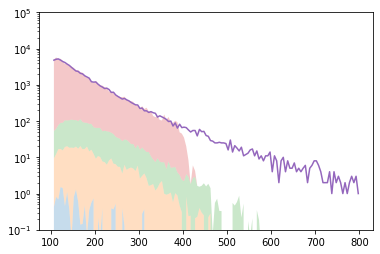

In [161]:
import matplotlib.pyplot as plt
plt.stackplot(center, [VB_nom,ST_nom,TT_nom,DY_nom], alpha=.25)
plt.errorbar(center, data_nom)
for nom,up, down in bff_plt_list:
    plt.plot(center, nom)
#plt.fill_between(center, up, down, alpha=.25)
plt.yscale('log')
plt.ylim(bottom=1e-1, top=1e5)

In [162]:
def fit_boost(bhist, sv_mult=8, **kwargs):
    import uncertainties
    centers = bhist.axes[0].centers
    #starting 
    bsum = bhist.sum().value*sv_mult
    p0 = [bsum,.5,90,90]
    popt, pcov = curve_fit(log_norm, bhist.axes[0].centers, bhist.values(), p0=p0, bounds=(-100,[np.inf,np.inf,100,np.inf]), **kwargs)
    popt_corr = uncertainties.correlated_values(popt, pcov)
    return popt_corr


def plot_unc(ax,x, yunp, color='black', numer = [],  **kwargs):
    y_nom, y_unc = unzip_unp(yunp)
    if len(numer)==0:
        ax.plot(x, y_nom, color=color, **kwargs)
        ax.fill_between(x, y_nom+y_unc, y_nom-y_unc, color=color, alpha=.25)
    else:
        y_nom = y_nom/numer
        y_unc = y_unc/numer
        ax.plot(x, y_nom, color=color, **kwargs)
        ax.fill_between(x, y_nom+y_unc, y_nom-y_unc, color=color, alpha=.25)

In [163]:
import boost_histogram as bh
from scipy.optimize import curve_fit

In [164]:
from bff_processor.utils import make_view, ratio_plot_template, nratio_plot_template, log_norm, log_norm_unp, unzip_unp

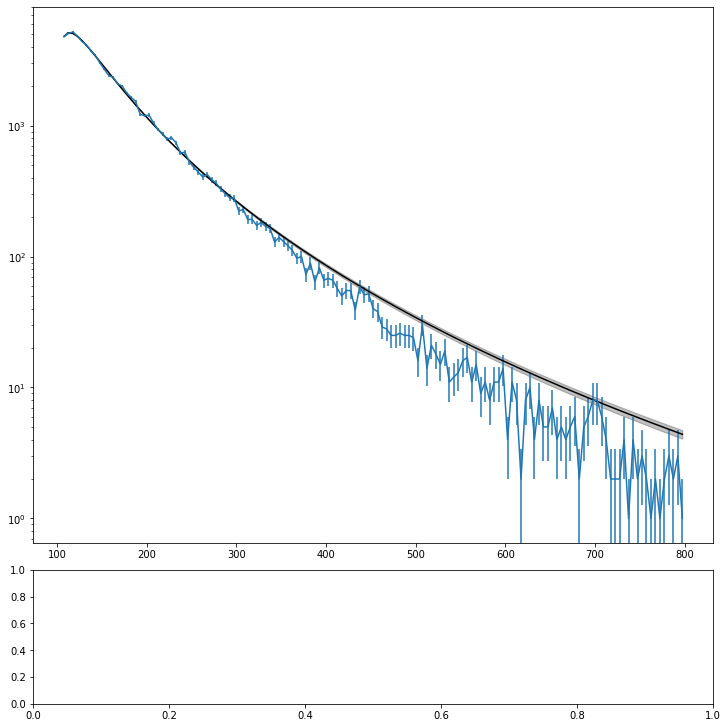

In [165]:
data_fit = fit_boost(data_dict[reg]) #fit_boost(bhist[0], sigma = bhist[0].variances()**.5, absolute_sigma=True)
data_yunp = log_norm_unp(center, *data_fit)
fig, top, bottom = ratio_plot_template( figsize=[10,10])
plot_unc(top,center, data_yunp)
top.errorbar(center, data_nom, yerr=data_err**.5)
top.set_yscale('log')

In [1]:
import zfit
from zfit import z

/home/ryan/Develop/Physics/bff_plotting_code_v3/env/lib/python3.8/site-packages/zfit/__init__.py:48: UserWarning: TensorFlow warnings are by default suppressed by zfit. In order to show them, set the environment variable ZFIT_DISABLE_TF_WARNINGS=0. In order to suppress the TensorFlow warnings AND this warning, set ZFIT_DISABLE_TF_WARNINGS=1.
  warnings.warn("TensorFlow warnings are by default suppressed by zfit."


In [8]:
def log_norm(x, norm, sigma, theta, mean):
    return norm/((x-theta)*sigma*2*3.14159)*np.exp(-(np.log((x-theta)/mean))**2/(2*sigma**2))
from math import pi
class LogNormPDF(zfit.pdf.ZPDF):
    """1-dimensional PDF implementing the exp(alpha * x) shape."""
    _PARAMS = ['sigma', 'theta', 'mean']  # specify which parameters to take

    def _unnormalized_pdf(self, x):  # implement function
        data = z.unstack_x(x)
        sigma = self.params['sigma']
        theta = self.params['theta']
        mean = self.params['mean']
        return 1./((data-theta)*sigma*2*pi)*z.exp(-(z.numpy.log(data-theta))**2/(2*sigma**2)) 

In [9]:
obs = zfit.Space("obs1", limits=(105, 899))
custom_pdf = LogNormPDF(obs=obs, sigma=.6, theta=80, mean=200)

In [10]:
integral = custom_pdf.integrate(limits=(105, 800))
sample = custom_pdf.sample(n=1000)
prob = custom_pdf.pdf(sample)

(array([613., 222.,  85.,  41.,  21.,  10.,   5.,   1.,   0.,   2.]),
 array([105.00139579, 107.40236688, 109.80333798, 112.20430908,
        114.60528017, 117.00625127, 119.40722237, 121.80819346,
        124.20916456, 126.61013565, 129.01110675]),
 <BarContainer object of 10 artists>)

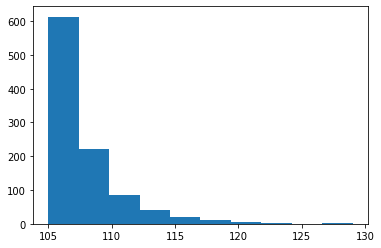

In [19]:
import matplotlib.pyplot as plt
plt.hist(sample.to_pandas())